In [1]:
import matplotlib.pyplot as plt

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
from rdkit import Chem
from rdkit.Chem import AllChem
import openpyxl

In [3]:
import os

In [4]:
TOP = os.getcwd().replace('notebooks', '')
raw_dir = TOP + 'data/raw/'
processed_dir = TOP + 'data/processed/'
interim_dir = TOP +'data/interim/'

In [5]:
df = pd.read_csv(interim_dir+'balanced_df_icf_140424.csv', index_col=[0])
df.head()

,Target,Analogue,Label,analogue_smi,target_smi,analogue_mol,target_mol,fps_target,fps_analogue,tanimoto,Euclidean
94147,DTXSID60626563,DTXSID6044068,1,CC1=C(C=C(C=C1N)[N+]([O-])=O)[N+]([O-])=O,CCCCCCC1=CC(=C(O)C(=C1)C(C)(C)C)C(C)(C)C,<rdkit.Chem.rdchem.Mol object at 0x7905c53ee3c0>,<rdkit.Chem.rdchem.Mol object at 0x7905c5311040>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,0.064516,7.615773
20729,DTXSID7027255,DTXSID1024621,1,COCCOCCOC,C\C=C\C,<rdkit.Chem.rdchem.Mol object at 0x7905c53ee430>,<rdkit.Chem.rdchem.Mol object at 0x7905c5311120>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,0.058824,4.000000
136459,DTXSID0074716,DTXSID9026714,0,CCCC(C)CO,CCCC(CO)CCC,<rdkit.Chem.rdchem.Mol object at 0x7905c53ee2e0>,<rdkit.Chem.rdchem.Mol object at 0x7905c53110b0>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,0.454545,3.464102
26548,DTXSID10497003,DTXSID0044571,0,CC(C)C1=CC=CC(O)=C1,CC(C)CC1=CC(O)=CC=C1,<rdkit.Chem.rdchem.Mol object at 0x7905c53ee510>,<rdkit.Chem.rdchem.Mol object at 0x7905c5311190>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,0.394737,4.795832
12767,DTXSID6022000,DTXSID8020044,1,OCC=C,NCCO,<rdkit.Chem.rdchem.Mol object at 0x7905c53ee580>,<rdkit.Chem.rdchem.Mol object at 0x7905c5311200>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,0.214286,3.316625


In [6]:
from rdkit import DataStructs
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem import AllChem

In [7]:
df['analogue_mol'] = [Chem.MolFromSmiles(e) for e in df['analogue_smi']]

df['target_mol'] = [Chem.MolFromSmiles(e) for e in df['target_smi']]


In [8]:
df['fp_target'] = [np.array(AllChem.GetMorganFingerprintAsBitVect(i,3,1024)) for i in df['target_mol']]

In [9]:
df['fp_analogue'] = [np.array(AllChem.GetMorganFingerprintAsBitVect(i,3,1024)) for i in df['analogue_mol']] 

In [13]:
df['fps_target'] = df['target_mol'].apply(lambda x: fpgen.GetFingerprint(x))

In [12]:
df['fps_analogue'] = df['analogue_mol'].apply(lambda x: fpgen.GetFingerprint(x))

In [11]:
fpgen = rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=1024)

In [14]:
def tanimoto(df):
    mylst = []
    for i, row in df.iterrows():
        sim= DataStructs.TanimotoSimilarity(row['fps_target'], row['fps_analogue'])
        mylst.append(sim)
    df['tanimoto'] = mylst
    return df

In [15]:
df = tanimoto(df)

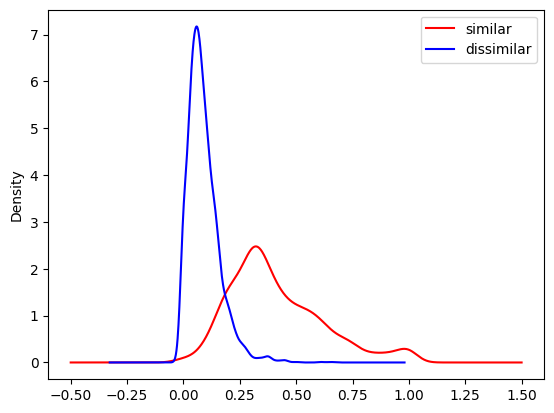

In [16]:
df[df['Label'] ==0]['tanimoto'].plot.kde(color = 'r', label = 'similar')
df[df['Label'] ==1]['tanimoto'].plot.kde(color = 'b', label = 'dissimilar')
plt.legend()

In [17]:
df[df['Label'] ==0]['tanimoto'].median()

0.36363636363636365

In [18]:
df[df['Label'] ==1]['tanimoto'].median()

0.07547169811320754

In [19]:
df['Label'].value_counts()

Label
1    2715
0    2715
Name: count, dtype: int64

In [20]:
df['Label'] = df['Label'].apply(lambda x: -1 if x==1 else 1)

In [21]:
df['fps_target'].values[0]

In [22]:
from sklearn.model_selection import train_test_split


In [23]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import balanced_accuracy_score, make_scorer

In [24]:
X_target = df['fp_target'].values
X_analogue = df['fp_analogue'].values
y = df['Label'].values

In [25]:
X_target

array([array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]),
       array([0, 1, 0, ..., 0, 0, 0]), ...,
       array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]),
       array([0, 1, 0, ..., 0, 0, 0])], dtype=object)

In [26]:
mylst = []
for a,b in zip(X_target, X_analogue):
    mylst.append([a,b])


In [27]:
len(mylst)

5430

In [28]:
analogue_pairs = np.asarray(mylst).reshape(5430,-1,1024)

In [29]:
analogue_pairs.shape

(5430, 2, 1024)

In [30]:
from metric_learn import ITML

from sklearn.model_selection import cross_validate, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import balanced_accuracy_score, f1_score, make_scorer, roc_auc_score
from sklearn.model_selection import StratifiedKFold


In [31]:
y.shape

(5430,)

In [33]:
indices = np.arange(1,df.shape[0]+1)
#indices

In [34]:
itml = ITML(random_state = 42)


In [35]:
pairs_train, pairs_test, y_train, y_test, idx1, idx2 = train_test_split(analogue_pairs, y, indices, test_size = 0.25, stratify=y, random_state = 42)

In [36]:
pairs_train.shape, pairs_test.shape, y_train.shape, y_test.shape

((4072, 2, 1024), (1358, 2, 1024), (4072,), (1358,))

In [37]:
baa = make_scorer(balanced_accuracy_score)

In [38]:
from sklearn.metrics import roc_auc_score

In [39]:
cv = StratifiedKFold(n_splits = 5)

In [40]:
result_itml = cross_validate(itml, pairs_train,  y_train, cv=cv, scoring = baa,return_train_score = True )

/home/grace/Documents/python/misc/graph/lib/python3.9/site-packages/metric_learn/itml.py:75: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = min(_lambda[i], gamma_proj * (1. / wtw - 1. / pos_bhat[i]))
/home/grace/Documents/python/misc/graph/lib/python3.9/site-packages/metric_learn/itml.py:75: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = min(_lambda[i], gamma_proj * (1. / wtw - 1. / pos_bhat[i]))
/home/grace/Documents/python/misc/graph/lib/python3.9/site-packages/metric_learn/itml.py:75: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = min(_lambda[i], gamma_proj * (1. / wtw - 1. / pos_bhat[i]))
/home/grace/Documents/python/misc/graph/lib/python3.9/site-packages/metric_learn/itml.py:75: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = min(_lambda[i], gamma_proj * (1. / wtw - 1. / pos_bhat[i]))
/home/grace/Documents/python/misc/graph/lib/python3.9/site-packages/metric_learn/itml.py:75: RuntimeWarning:

In [41]:
cv_results = pd.DataFrame(result_itml)

In [42]:
cv_results

,fit_time,score_time,test_score,train_score
0,767.646083,0.039243,0.952197,0.995701
1,739.794926,0.020607,0.952113,0.996623
2,709.616858,0.020607,0.958231,0.995089
3,642.182565,0.020232,0.942260,0.995703
4,591.865060,0.020187,0.953317,0.994782


In [44]:
cv_results['test_score'].mean(), cv_results['test_score'].std()

(0.9516235486823721, 0.005804330893044246)

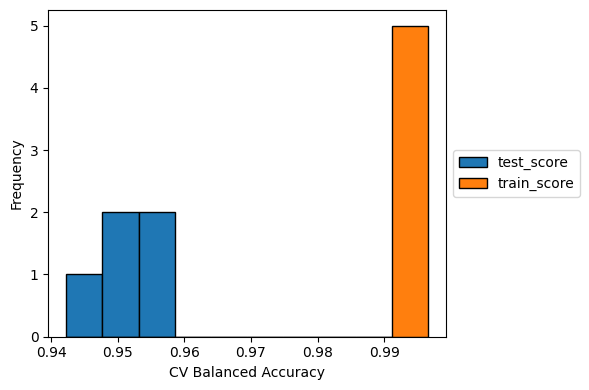

In [45]:
cv_results[['test_score', 'train_score']].plot.hist(edgecolor = 'black', figsize = (6,4))
plt.xlabel('CV Balanced Accuracy')
plt.legend(loc = 'center left', bbox_to_anchor = (1,0.5))
plt.tight_layout()

In [46]:
def cv_run(gamma):
    a =cross_validate(ITML(random_state=42, gamma = gamma), pairs_train, y_train, cv=cv, scoring = make_scorer(balanced_accuracy_score), n_jobs=-1, return_estimator=True) 
    return a['test_score'].mean()

In [47]:
gammas = [0.25,0.5,0.75,1,5,10]
grid_search = []
for gamma in gammas:
    grid_search.append([gamma, cv_run(gamma)])

/home/grace/Documents/python/misc/graph/lib/python3.9/site-packages/metric_learn/itml.py:75: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = min(_lambda[i], gamma_proj * (1. / wtw - 1. / pos_bhat[i]))
/home/grace/Documents/python/misc/graph/lib/python3.9/site-packages/metric_learn/itml.py:75: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = min(_lambda[i], gamma_proj * (1. / wtw - 1. / pos_bhat[i]))
/home/grace/Documents/python/misc/graph/lib/python3.9/site-packages/metric_learn/itml.py:75: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = min(_lambda[i], gamma_proj * (1. / wtw - 1. / pos_bhat[i]))
/home/grace/Documents/python/misc/graph/lib/python3.9/site-packages/metric_learn/itml.py:75: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = min(_lambda[i], gamma_proj * (1. / wtw - 1. / pos_bhat[i]))
/home/grace/Documents/python/misc/graph/lib/python3.9/site-packages/metric_learn/itml.py:75: RuntimeWarning:

In [48]:
grid_search

[[0.25, 0.9383605530664354],
 [0.5, 0.9474460422989834],
 [0.75, 0.9528514477043888],
 [1, 0.9516235486823721],
 [5, 0.9169912559618443],
 [10, 0.8803909524497758]]

In [49]:
best_model = ITML(random_state=42, gamma = 0.75)

In [50]:
best_model.fit(pairs_train, y_train)

/home/grace/Documents/python/misc/graph/lib/python3.9/site-packages/metric_learn/itml.py:75: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = min(_lambda[i], gamma_proj * (1. / wtw - 1. / pos_bhat[i]))


ITML(gamma=0.75, random_state=42)

In [51]:
y_pred = best_model.predict(pairs_test)

In [52]:
roc_auc_score(y_test, y_pred)

0.9521354933726067

In [53]:
balanced_accuracy_score(y_test, y_pred)

0.9521354933726067

In [54]:
from sklearn.metrics import confusion_matrix, classification_report

In [55]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.93      0.98      0.95       679
           1       0.98      0.92      0.95       679

    accuracy                           0.95      1358
   macro avg       0.95      0.95      0.95      1358
weighted avg       0.95      0.95      0.95      1358



In [56]:
confusion_matrix(y_test, y_pred)

array([[667,  12],
       [ 53, 626]])